In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

Using TensorFlow backend.


# Load data

In [2]:
filename = "../data/cnn_input/test_gemini_BTCUSD_Close_2H_LWS3_IWS20_Trf['RP', 'GADF', 'MTF'].npz"

### Image window sizes

In [3]:
Image_window_size = np.int(filename[filename.find('_IWS') + 4 : filename.find("_Trf")])
Image_window_size

20

### Transformation types

In [4]:
Image_trf = eval(filename[filename.find('_Trf')+4:filename.find('.npz')])
Image_trf

['RP', 'GADF', 'MTF']

In [5]:
num_color_channels = len(Image_trf)
num_color_channels

3

#### In case file is missing run the data-check-and-prep with preferred settings and use the new file's name (cannot upload too big files to Git)

In [6]:
data = np.load(filename)

In [7]:
images = data['images']
image_labels = data['image_labels']
label_names = data['label_names']

# Check data

In [8]:
# for quick check: only 1000 images
# images = images[:1000]
# image_labels = image_labels[:1000]

In [9]:
images.shape

(3, 12575, 20, 20)

In [10]:
image_labels.shape

(12575, 3)

In [11]:
print("max: {}; min: {}".format(np.amax(images), np.amin(images)))

max: 1.0; min: 0.0


In [12]:
label_names = label_names.item()
label_names

{2: 'Sell', 0: 'Buy', 1: 'Hold'}

## e.g.:

Transformation type: RP


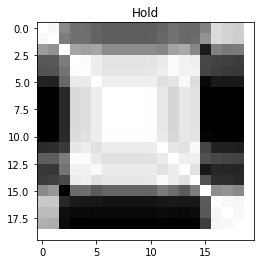

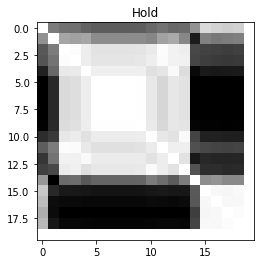

Transformation type: GADF


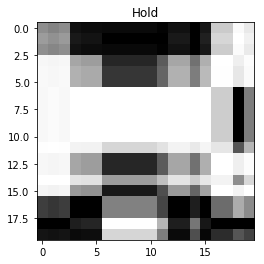

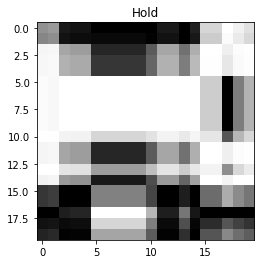

Transformation type: MTF


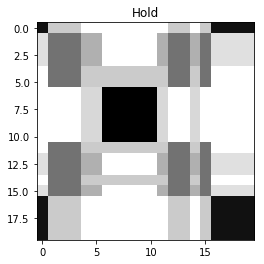

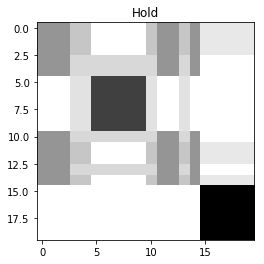

In [13]:
for trfidx, trf in enumerate(Image_trf):
    print('Transformation type: ' + trf)
    for idx, image in enumerate(images[trfidx,:2,:,:]):
        plt.imshow(image, cmap = "Greys")
        plt.title(label_names[np.int(np.argwhere(image_labels[idx]))])
        plt.show()

## Baseline
Choosing the biggest class to be the class of all gives the accuracy of:

In [14]:
np.max(np.sum(image_labels, 0))/np.sum(image_labels)

0.4842942345924453

## Reshape

In [15]:
images = np.moveaxis(images,0,-1)

In [16]:
print("Images shape : {}; Labels shape : {}".format(images.shape, image_labels.shape))

Images shape : (12575, 20, 20, 3); Labels shape : (12575, 3)


**The shape we need:**

Images shape : (obs, image_dim, image_dim, num_color_channels); Labels shape : (obs, num_classes)

# Train - test split without overlap

In [17]:
images_train, images_test, image_labels_train, image_labels_test = train_test_split(images, 
                                                                                    image_labels, 
                                                                                    test_size = .2, 
                                                                                    random_state = 22
                                                                                   )

## We need to get rid of the first (Image Window Size -1) test data to avoid lookahead bias.

In [18]:
images_test = images_test[(Image_window_size-1):]
image_labels_test = image_labels_test[(Image_window_size-1):]

In [19]:
print("Train images shape : {}; Train labels shape : {}".format(images_train.shape, image_labels_train.shape))

Train images shape : (10060, 20, 20, 3); Train labels shape : (10060, 3)


In [20]:
print("Test images shape : {}; Test labels shape : {}".format(images_test.shape, image_labels_test.shape))

Test images shape : (2496, 20, 20, 3); Test labels shape : (2496, 3)


# The Deep CNN

### Custom Keras Eval metrics: F1 Score

In [21]:
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

### Network Parameters

In [22]:
# image shape (d x d)
n_input = images_train.shape[1]
inputShape = (n_input, n_input, num_color_channels)

# number of classes
n_classes =  image_labels_train.shape[1]

# dropout
to_drop = 0.2 # prob. to DROP 

## Building the model

In [23]:
def createModel(input_shape, dropout = .2):
    model = Sequential()
    # Input
    model.add(Conv2D(32, 
                     (3, 3), 
                     padding='same', 
                     activation='relu', 
                     input_shape=input_shape))
    
    # Convolutions, pooling
    model.add(Conv2D(32, 
                     (3, 3),
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
  
    model.add(Conv2D(64, (3, 3), 
                     padding='same', 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
  
    model.add(Conv2D(128, (3, 3), 
                     padding='same', 
                     activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
      
    # Flatten & Dense layers 
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    
    model.add(Dense(n_classes, activation='softmax'))
  
    return model

In [24]:
model1 = createModel(dropout = to_drop, input_shape = inputShape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Hyperparameter settings

In [25]:
training_iters = 100
batch_size = 128

### Accounting for imbalance

In [26]:
label_names

{2: 'Sell', 0: 'Buy', 1: 'Hold'}

In [27]:
np.sum(image_labels, axis = 0)/np.sum(image_labels)

array([0.26091451, 0.48429423, 0.25479125])

In [28]:
y_ints = [y.argmax() for y in image_labels_train]
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.2798982188295165, 1: 0.6899862825788752, 2: 1.2997416020671835}

## Compiling

In [29]:
model1.compile(optimizer='adam',
               loss='categorical_crossentropy', 
               metrics=['accuracy', f1])


## Training

In [30]:
history = model1.fit(images_train, 
                     image_labels_train, 
                     batch_size=batch_size, 
                     epochs=training_iters, verbose=1,
                     validation_data=(images_test, image_labels_test),
                     class_weight=class_weight_dict
                    )
  
model1.evaluate(images_test, image_labels_test)

Instructions for updating:
Use tf.cast instead.
Train on 10060 samples, validate on 2496 samples
Epoch 1/100
10060/10060 [==============================] - 19s 2ms/step - loss: 1.0943 - acc: 0.3550 - f1: 5.3188e-04 - val_loss: 1.0124 - val_acc: 0.3970 - val_f1: 0.1352
Epoch 2/100
10060/10060 [==============================] - 16s 2ms/step - loss: 0.8099 - acc: 0.4841 - f1: 0.3854 - val_loss: 0.8109 - val_acc: 0.4796 - val_f1: 0.4147
Epoch 3/100
10060/10060 [==============================] - 16s 2ms/step - loss: 0.7525 - acc: 0.4803 - f1: 0.4210 - val_loss: 0.8346 - val_acc: 0.4748 - val_f1: 0.4154
Epoch 4/100
10060/10060 [==============================] - 16s 2ms/step - loss: 0.7274 - acc: 0.4886 - f1: 0.4249 - val_loss: 0.8023 - val_acc: 0.4784 - val_f1: 0.4196
Epoch 5/100
 9984/10060 [============================>.] - ETA: 0s - loss: 0.7113 - acc: 0.4987 - f1: 0.4357

KeyboardInterrupt: 

## Loss & Accuracy Curves

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
